['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


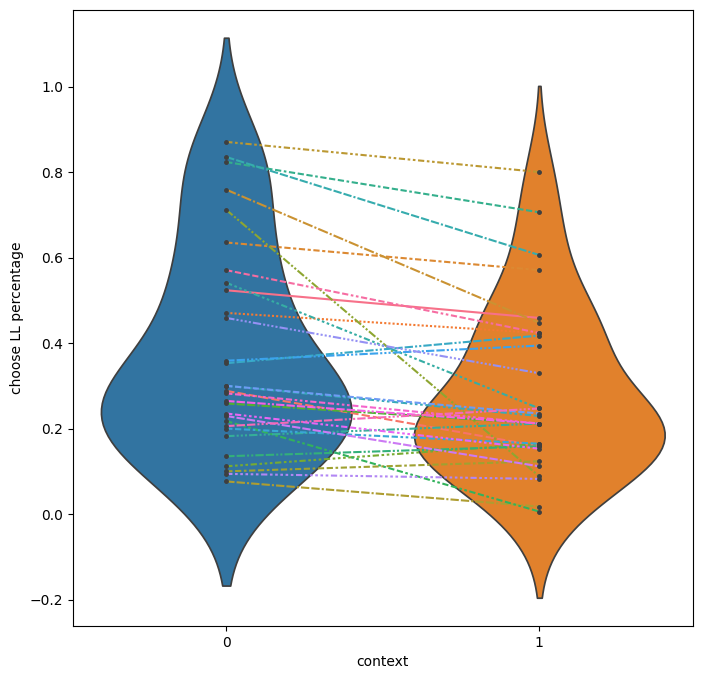

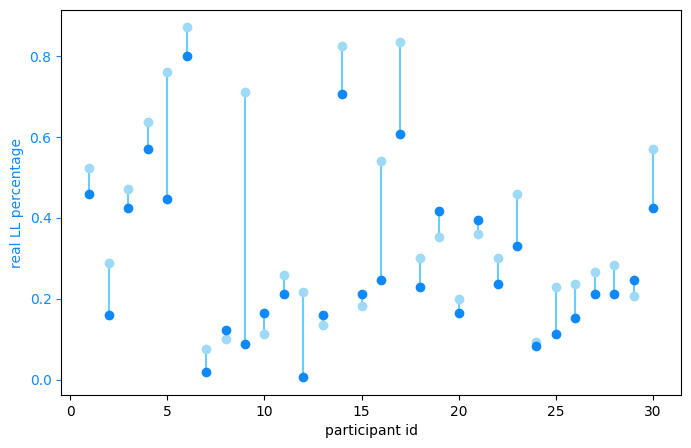

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 9 2024

@author: Yaning
"""

# get the real percentage of the participants
%run Documents/pyro_models/files_to_run/percentage_comparison.ipynb
# %run Documents/pyro_models/files_to_run/data_analysis(matlab_dataset).ipynb

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 
import pickle

In [2]:
trial_num = data.shape[2]
info_num = data.shape[3]
real_percentages = []

for i in data:
    context_percentages = []
    for j in i:
        context_percentages.append(len(list(filter(lambda x: (x == 1), j[:,4]))
                ) / len(j))
    real_percentages.append(context_percentages)

line_data = []
for i,j in zip(real_percentages[0], real_percentages[1]):
    line_data.append([i,j])

real_percentages = np.array(real_percentages)

In [3]:
data[:,:,:,1]

array([[[20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        ...,
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.]],

       [[20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        ...,
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.],
        [20., 20., 20., ..., 20., 20., 20.]]])

In [3]:
# load inferred parameters
with open('Documents/pyro_models/files_to_run/results/shift_0.pkl', 'rb') as f:
    pos_dict = pickle.load(f)

In [4]:
pos_params = pos_dict['m_locs']

In [5]:
pos_params.shape

(30, 5)

In [7]:
# transfer the inferred parameters to cpu
pos_mean_u = pos_params[:,0]
pos_sigma_u = np.exp(pos_params[:,1])
pos_sigma_es = np.exp(pos_params[:,2])
pos_beta = np.exp(pos_params[:,3])
pos_shift_mean_u = pos_params[:,4]
pos_shift_sigma_u = pos_params[:,5]
pos_shift_sigma_es = pos_params[:,6]

In [6]:
# sigma_rate shift model
pos_mean_u = pos_params[:,0]
pos_sigma_rate = np.exp(pos_params[:,1])
pos_beta = np.exp(pos_params[:,2])
pos_shift_mean_u = pos_params[:,3]
pos_shift_sigma_rate = pos_params[:,4]

In [ ]:
# # transfer the time perception params
# pos_a = np.exp(pos_params[:,7])
# pos_b = np.exp(pos_params[:,8])

pos_time = pos_params[:,7]

In [9]:
print(pos_shift_sigma_es)
# print(pos_mean_u)

[ 0.09891961  0.25600803  0.07487744  0.10007701  0.47589418  0.16098216
  0.28329518  0.0460178   1.4403834  -0.08150935  0.03758564  1.0911489
 -0.00656382  0.09177455 -0.07566572  0.8685944   0.45508954  0.10709659
 -0.02028608  0.08073249 -0.04175109  0.10821186  0.24617574  0.00232477
  0.4055297   0.09887421  0.03989142  0.19202694 -0.04410997  0.20195542]


In [8]:
# replicate the inferred parameters to trial_num (trial amount)
temp = pos_mean_u + pos_shift_mean_u
mean_u_cafe = pos_mean_u
mean_u_gamble = temp
mean_u = np.concatenate((pos_mean_u, temp))
mean_u_repeat = np.tile(mean_u[:, np.newaxis], (1, trial_num))

# temp = pos_sigma_u + pos_shift_sigma_u
# sigma_u_cafe = np.exp(pos_sigma_u)
# sigma_u_gamble = np.exp(temp)
# sigma_u = np.concatenate((sigma_u_cafe, sigma_u_gamble))
# sigma_u_repeat = np.tile(sigma_u[:, np.newaxis], (1, trial_num))

# temp = pos_sigma_es + pos_shift_sigma_es
# sigma_es_cafe = np.exp(pos_sigma_es)
# sigma_es_gamble = np.exp(temp)
# sigma_es = np.concatenate((sigma_es_cafe, sigma_es_gamble))
# sigma_es_repeat = np.tile(sigma_es[:, np.newaxis], (1, trial_num))

beta = np.concatenate((pos_beta, pos_beta))
beta_repeat = np.tile(beta[:, np.newaxis], (1, trial_num))

# the sigma_rate shift model
temp = pos_sigma_rate + pos_shift_sigma_rate
sigma_rate_cafe = np.exp(pos_sigma_rate)
sigma_rate_gamble = np.exp(temp)
sigma_rate = np.concatenate((sigma_rate_cafe, sigma_rate_gamble))
sigma_rate_repeat = np.tile(sigma_rate[:, np.newaxis], (1, trial_num))


# # also mean_u is positive constrained (log_mean_u)
# temp = pos_log_mean_u + pos_shift_log_mean_u
# mean_u_cafe = np.exp(pos_log_mean_u)
# mean_u_gamble = np.exp(temp)
# mean_u = np.concatenate((mean_u_cafe, mean_u_gamble))
# mean_u_repeat = np.tile(mean_u[:, np.newaxis], (1, trial_num))

# # # add time perception Tp = a*log(Tr + b)
# a = np.concatenate((pos_a, pos_a))
# a_repeat = np.tile(a[:, np.newaxis], (1, trial_num))

# b = np.concatenate((pos_b, pos_b))
# b_repeat = np.tile(b[:, np.newaxis], (1, trial_num))

# another way to add time perception
# time = np.concatenate((pos_time, pos_time))
# time_repeat = np.tile(time[:, np.newaxis], (1, trial_num))

In [11]:
mean_u_repeat.shape

(60, 170)

In [12]:
# get the range of the inferred params
# use them in parameter recovery
print("mean_u")
print(min(pos_mean_u), max(pos_mean_u))
print(min(pos_shift_mean_u), max(pos_shift_mean_u))
print("sigma_u")
print(min(pos_sigma_u), max(pos_sigma_u))
print(min(pos_shift_sigma_u), max(pos_shift_sigma_u))
print("sigma_es")
print(min(pos_sigma_es), max(pos_sigma_es))
print(min(pos_shift_sigma_es), max(pos_shift_sigma_es))
print("beta")
print(min(beta), max(beta))

mean_u
0.31570223 1.4009875
-2.3374043 1.5923086
sigma_u
0.6055068 2.5576851
-1.4155667 0.076656744
sigma_es
0.38718945 1.6603771
-0.08150935 1.4403834
beta
0.048845183 0.40079778


In [13]:
# get the range of the inferred params
# use them in parameter recovery
print("mean_u")
print(mean(pos_mean_u))
print(mean(pos_shift_mean_u))
print("sigma_u")
print(mean(pos_sigma_u))
print(mean(pos_shift_sigma_u))
print("sigma_es")
print(mean(pos_sigma_es))
print(mean(pos_shift_sigma_es))
print("beta")
print(mean(beta))

mean_u
0.68252325
0.34788752
sigma_u
1.2042593
-0.22277783
sigma_es
0.97562766
0.22311936
beta
0.2533142


In [9]:
real_data = data
real_data = real_data.reshape(60,trial_num,info_num)

In [11]:
# # use real data condition and the inferred parameters to get estimation values
# inferred_estimation = (mean_u_repeat*real_data[:,:,2]*sigma_es_repeat**2 + 
#  real_data[:,:,3]*sigma_u_repeat**2)/(real_data[:,:,2]*sigma_es_repeat**2 + sigma_u_repeat**2)

# sigma_rate model
inferred_estimation = (mean_u_repeat*real_data[:,:,2]*sigma_rate_repeat**2 + 
 real_data[:,:,3])/(real_data[:,:,2]*sigma_rate_repeat**2 + 1)

# # make the mean_u constant
# inferred_estimation = (torch.tensor(1.)*real_data[:,:,2]*sigma_es_repeat**2 + 
#  real_data[:,:,3]*sigma_u_repeat**2)/(real_data[:,:,2]*sigma_es_repeat**2 + sigma_u_repeat**2)

# # add time perception Tp = a*log(Tr + b)
# inferred_estimation = (mean_u_repeat*a_repeat*np.log(real_data[:,:,2] + b_repeat)*sigma_es_repeat**2 + 
#  real_data[:,:,3]*sigma_u_repeat**2)/(a_repeat*np.log(real_data[:,:,2]+ b_repeat)*sigma_es_repeat**2 + sigma_u_repeat**2)

# # another way to add time perception delay = time*delay
# inferred_estimation = (mean_u_repeat*time_repeat*real_data[:,:,2]*sigma_es_repeat**2 + 
#  real_data[:,:,3]*sigma_u_repeat**2)/(time_repeat*real_data[:,:,2]*sigma_es_repeat**2 + sigma_u_repeat**2)

# change everything to tensor
real_data = torch.tensor(real_data)
inferred_estimation = torch.tensor(inferred_estimation)
beta = torch.tensor(beta_repeat)

# create softmax and the bernoulli distribution
softmax_args = torch.stack([beta*inferred_estimation, beta*real_data[:,:,1]])
p = torch.softmax(softmax_args, dim = 0)[0]
inferred_response_distr = Bernoulli(probs=p)





In [12]:
# get one possible predict actions
inferred_response = inferred_response_distr.sample()

In [13]:
# reshape to with contexts for plotting
reshaped_inferred_response = inferred_response.reshape(2,30,trial_num)

Check the graph fitting.

In [14]:
# calculate the predicted LL choosing percentage
inferred_percentages = []
for i in reshaped_inferred_response:
    temp = []
    for j in i:
        temp.append(len(list(filter(lambda x: (x == 1), j))
                ) / len(j))
    inferred_percentages.append(temp)

In [15]:
inferred_percentages = np.array(inferred_percentages)

In [16]:
# separate to pairs so can make line plot
infer_line = []
for i,j in zip(inferred_percentages[0], inferred_percentages[1]):
    infer_line.append([i,j])

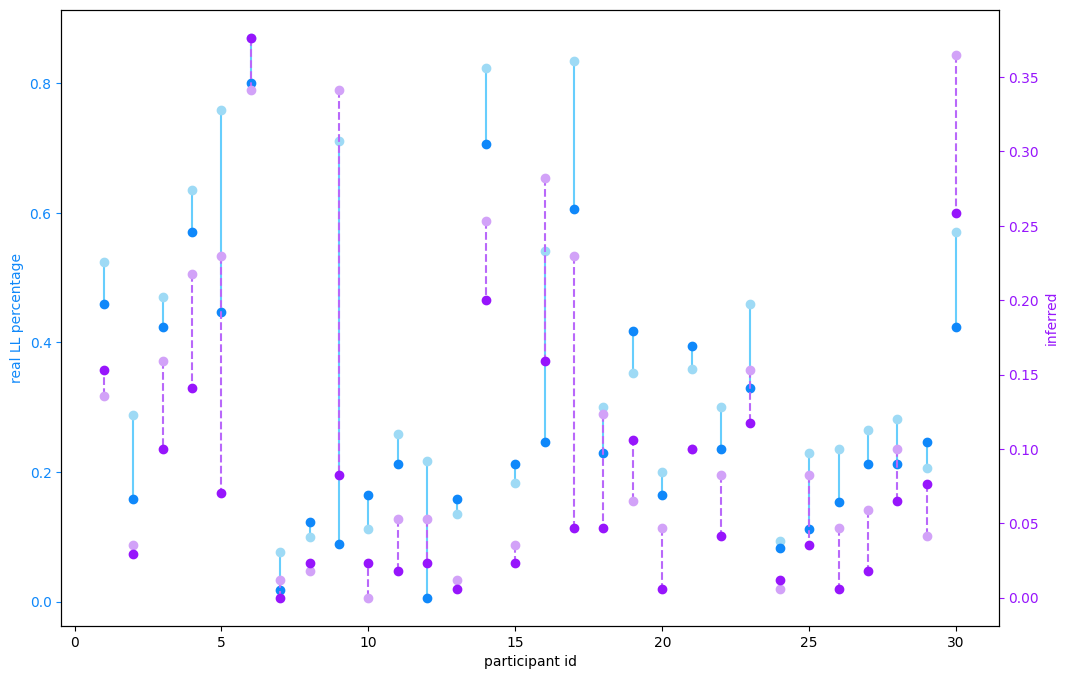

In [17]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

# inferred percentages (purple)
for i in range(len(infer_line)):
    x = [i+1, i+1]
    y_inferred = [infer_line[i][0], infer_line[i][1]]
    axes[1].plot(x, y_inferred, color="#b968fa", ls = "--")
    axes[1].plot(i+1, y_inferred[0], color = "#d2a2f8", marker = "o")
    axes[1].plot(i+1, y_inferred[1], color = "#9715fc", marker = "o")
axes[1].set_ylabel("inferred", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")



plt.show()

Check the correctly predicted percentage.

In [18]:
# create only one dimension array
# get how many are correctly predicted
real_response = real_data[:,:,4].view(-1)
num = 0
for i in range(len(real_response)):
    if inferred_response.view(-1)[i] == real_response[i]:
        num = num + 1

In [19]:
num/len(real_response)

0.7223529411764706

Plot the parameters with the real LL choosing percentage.

In [142]:
np.corrcoef(sigma_u_cafe, sigma_es_cafe)

array([[ 1.        , -0.64433997],
       [-0.64433997,  1.        ]])

In [109]:
np.corrcoef(mean_u, sigma_u)

array([[ 1.        , -0.50153953],
       [-0.50153953,  1.        ]])

In [77]:
np.corrcoef(sigma_u_gamble, mean_u_gamble)

array([[1.        , 0.32726915],
       [0.32726915, 1.        ]])

In [161]:
np.corrcoef(pos_shift_sigma_u, pos_shift_sigma_es)

array([[ 1.        , -0.99992013],
       [-0.99992013,  1.        ]])

In [97]:
mean(sigma_es_gamble)

3.6593907

In [99]:
mean(sigma_es_gamble[[4,8,11,15,16,24,29]])

4.940537

In [84]:
mean(sigma_u_gamble) - mean(sigma_es_gamble)

-0.5585606

In [82]:
mean(sigma_es_gamble)

3.6593907

In [20]:
# plot_pos_param = pos_sigma_es.reshape(2,30) - pos_sigma_u.reshape(2,30)
plot_param = sigma_es.reshape(2,30)

In [21]:
# separate to pairs so can make line plot
param_line = []
for i,j in zip(plot_param[0], plot_param[1]):
    param_line.append([i,j])

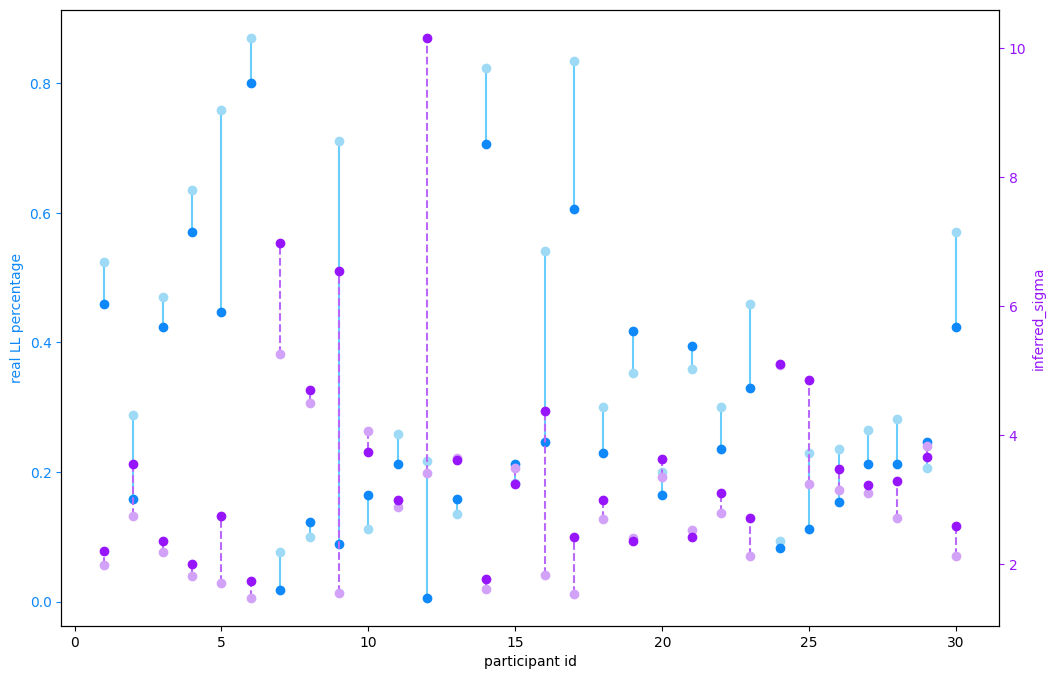

In [22]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

# inferred percentages (purple)
for i in range(len(param_line)):
    x = [i+1, i+1]
    y_inferred = [param_line[i][0], param_line[i][1]]
    axes[1].plot(x, y_inferred, color="#b968fa", ls = "--")
    axes[1].plot(i+1, y_inferred[0], color = "#d2a2f8", marker = "o")
    axes[1].plot(i+1, y_inferred[1], color = "#9715fc", marker = "o")
axes[1].set_ylabel("inferred_sigma", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")



plt.show()

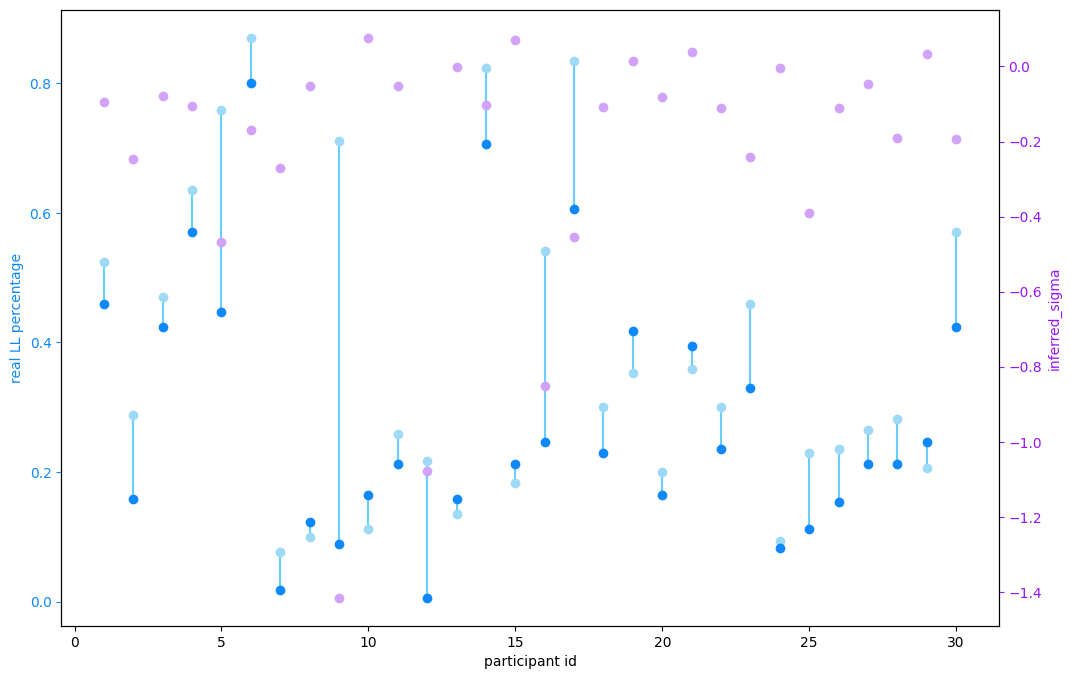

In [23]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

params = pos_shift_sigma_u
# inferred percentages (purple)
for i in range(len(params)):
    x = i+1
    y_inferred = params[i]
    axes[1].plot(x, y_inferred, color = "#d2a2f8", marker = "o")
axes[1].set_ylabel("inferred_sigma", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")


plt.show()

In [24]:
gaps = real_percentages[0] - real_percentages[1]

In [25]:
sum = real_percentages[0] + real_percentages[1]

In [26]:
smaller_sum = []
bigger_sum = []

sum_mean = mean(sum)

for i in range(len(sum)):
    if sum[i] <= sum_mean:
        smaller_sum.append(i)
    else:
        bigger_sum.append(i)

In [27]:
percentage_mean = []
for i in range(real_percentages.shape[1]):
    percentage_mean.append((real_percentages[0, i] +real_percentages[1,i])/2)

In [28]:
# separate into two groups
smaller_gap = []
bigger_gap = []

gaps_mean = mean(gaps)

for i in range(len(gaps)):
    if gaps[i] <= gaps_mean:
        smaller_gap.append(i)
    else:
        bigger_gap.append(i)

In [29]:
print(smaller_sum)
print(smaller_gap)

[1, 6, 7, 9, 10, 11, 12, 14, 17, 19, 21, 23, 24, 25, 26, 27, 28]
[0, 2, 3, 5, 6, 7, 9, 10, 12, 14, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28]


In [30]:
print(bigger_sum)
print(bigger_gap)

[0, 2, 3, 4, 5, 8, 13, 15, 16, 18, 20, 22, 29]
[1, 4, 8, 11, 13, 15, 16, 22, 24, 29]


In [31]:
smaller = sigma_es_cafe

In [32]:
for i in smaller:
    print(i)

1.9862176
2.7442853
2.184937
1.8053411
1.7002876
1.4728355
5.261295
4.491599
1.5519155
4.0595603
2.8752155
3.4142182
3.641803
1.6120572
3.4917095
1.8312846
1.5321167
2.6905353
2.4060402
3.3519208
2.5242453
2.7850463
2.115532
5.083929
3.2391136
3.1381295
3.1035473
2.70557
3.8295627
2.1193047


In [33]:
bigger = sigma_es_gamble

In [34]:
t_statistic, p_value = stats.ttest_ind(smaller, bigger, equal_var=False)

In [35]:
p_value

0.039088160096584244

In [42]:
max(sigma_es)

10.166495

In [51]:
np.corrcoef(pos_shift_sigma_u, pos_shift_sigma_es)

array([[ 1.        , -0.99986835],
       [-0.99986835,  1.        ]])